In [1]:

# !conda install -c mjirik -c simpleitk -c conda-forge io3d=2.10.6 sed3=1.6.3 simpleitk keras-applications
!pip install io3d sed3 loguru pydicom SimpleITK imma ruamel.yaml pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.5/80.5 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sed3: filename=sed3-1.4.3-py3-none-any.whl size=11721 sha256=59931bc36b5ef93afef5b42ec4a1f7dd92daa6304c02cc347271277ad9ae7ba4
  Stored in directory: /root/.cache/pip/wheels/03/b5/bb/ddcf4d8708d9a93f42aa605947c9bfe90da1e4634bfc3956ef
  Created wheel for imma: filename=imma-0.17.4-py3-none-any.whl size=25086 sha256=1639d2a34043cb55b427ef56611cb6973f99355ec82231ed91ce8477aa489f0c
  Stored in directory: /root/.cache/pip/wheels/25/32/bd/e187f1cd2dfe4a3eb2d3ba9783c1c63fe8270e30fe8a5824a7
Successfully built sed3 imma


In [1]:
pip install h5py

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install --upgrade scipy

In [3]:

from __future__ import print_function
import cv2
import tensorflow as tf
import os
from skimage.transform import resize
from skimage.io import imsave
import numpy as np

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import History
from skimage.exposure import rescale_intensity
from skimage import io
# from data import load_train_data, load_test_data
from sklearn.utils import class_weight
import pandas as pd
# import imma.volumetry_evaluation as ve

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [4]:
import h5py


# 

In [5]:
import tensorflow as tf
from loguru import logger
#import io3d
#import io3d.datasets
import sed3
import numpy as np
import matplotlib.pyplot as plt
logger.enable("io3d")
logger.disable("io3d")
import matplotlib.pyplot as plt
import h5py
import json
from pathlib import Path
import requests
from tqdm import tqdm
from numbers import Number
from typing import Optional
from glob import glob
import skimage
import sys
import os
import random
print(sys.version_info)
print(sys.executable)
print(os.getcwd())

ModuleNotFoundError: No module named 'loguru'

In [ ]:
import skimage

In [ ]:
def unzip(input_file:Path, output_dir=None):
    from zipfile import ZipFile
    with ZipFile(input_file,"r") as zip_ref:
         for file in tqdm(
             iterable=zip_ref.namelist(),
             total=len(zip_ref.namelist()),
             desc=str(Path(input_file).name)
             ):
              zip_ref.extract(member=file, path=output_dir)

def classes_from_coco(annotation_file:Path):
    with open(annotation_file) as f:
        ann = json.load(f)
    _, cfg_classes = zip(*sorted([(cat["id"], cat["name"]) for cat in ann["categories"]]))
    return cfg_classes

def mywget(url, fname, force=False):
    fname = Path(fname)
    if fname.exists() and ~force:
        print(f"File already exists. Use force=True to owerwrite.")
        return
    fname.parent.mkdir(parents=True, exist_ok=True)

    response = requests.get(url, stream=True)
    total_size_in_bytes= int(response.headers.get('content-length', 0))
    block_size = 1024 #1 Kibibyte
    progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
    with open(fname, 'wb') as file:
        for data in response.iter_content(block_size):
            progress_bar.update(len(data))
            file.write(data)
    progress_bar.close()
    if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
        print("ERROR, something went wrong")

In [ ]:

from __future__ import print_function

import tensorflow as tf
import os
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import History
from skimage.exposure import rescale_intensity
from skimage import io
# from data import load_train_data, load_test_data
from sklearn.utils import class_weight
import pandas as pd
# import imma.volumetry_evaluation as ve

In [7]:
K.set_image_data_format('channels_last')  # TF dimension ordering in this code

img_rows = int(512/2)
img_cols = int(512/2)
smooth = 1.
#We divide here the number of rows and columns by two because we undersample our data (We take one pixel over two)

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    #Dice=(2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    #IoU = (Dice *(K.sum(y_true_f) + K.sum(y_pred_f) + smooth)) / (2 - Dice)
    #print("Intersection over Union")
    #tensorflow .print(IoU)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
def IoU(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(K.maximum(y_true_f, y_pred_f))
    return(intersection/union)
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)
def IoU2(y_true, y_pred):
    return -IoU(y_true, y_pred)
#The functions return our metric and loss

In [8]:
IoU([0,0.5],[0,1])

InvalidArgumentError: cannot compute Mul as input #1(zero-based) was expected to be a float tensor but is a int32 tensor [Op:Mul]

In [9]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [10]:
def preprocess(imgs, is_mask=False):
    imgs_p = np.ndarray((imgs.shape[0], img_rows, img_cols), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        imgs_p[i] = resize(imgs[i], (img_cols, img_rows), preserve_range=True)

    imgs_p = imgs_p[..., np.newaxis]
    if is_mask:
        imgs_p = (imgs_p > 0).astype('float32')

    else:
        imgs_p = imgs_p.astype('float32')
    return imgs_p

#We adapt here our dataset samples dimension so that we can feed it to our network

In [11]:
import tensorflow

In [12]:
# one_weight = (1-num_of_ones)/(num_of_ones + num_of_zeros)
# zero_weight = (1-num_of_zeros)/(num_of_ones + num_of_zeros)

def weighted_binary_crossentropy(zero_weight, one_weight):

    def weighted_binary_crossentropy(y_true, y_pred):

        b_ce = K.binary_crossentropy(y_true, y_pred)

        # weighted calc
        weight_vector = y_true * one_weight + (1 - y_true) * zero_weight
        weighted_b_ce = weight_vector * b_ce

        return K.mean(weighted_b_ce)

    return weighted_binary_crossentropy

In [13]:
def get_unet2(class_weights=None):
    if class_weights is None:
        class_weights = [0.05956, 3.11400]
        #{0: 0.5956388648542532, 1: 3.1140000760253925}

    inputs = Input((img_rows, img_cols, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
#     conv10 = Conv2D(2, (1, 1), activation='softmax')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer='SGD',  loss=weighted_binary_crossentropy(class_weights[0], class_weights[1]), metrics=[dice_coef, "accuracy", IoU])
    #opt = keras.optimizers.SGD(learning_rate=0.001)
    #optimizer = 'rmsprop'
    #optimizer = 'rmsprop'

    #optimaizer pro detectron = sgd?
    return model

#The different layers in our neural network model (including convolutions, maxpooling and upsampling)

In [14]:
def save_segmentations(imgs_test, imgs_mask_test, pred_dir='preds'):

    if not os.path.exists(pred_dir):
        os.mkdir(pred_dir)

    for k in range(len(imgs_mask_test)):
        a=rescale_intensity(imgs_test[k][:,:,0],out_range=(0,255)).astype(np.uint8)
        b=(imgs_mask_test[k][:,:,0] > 0.5).astype('uint8')
        io.imsave(os.path.join(pred_dir, f'{k:05}_pred.png'),(255 * mark_boundaries(a,b)).astype(np.uint8))

In [15]:
import cv2

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
# from keras.layers.advanced_activations import LeakyReLU
from keras.layers import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model
import tensorflow as tf
import glob
import random
#import cv2
from random import shuffle
from typing import Tuple

In [17]:

from __future__ import print_function
import keras
import tensorflow as tf
import os
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

# inheritance for training process plot
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))

        # #choose a random test image and preprocess
        # x, y = next(example_generator)
        # raw = preprocess(x[:,:,0])[0]
        # # raw = raw[:,:,0:3]

        # # predict the mask
        # pred = model.predict(np.expand_dims(raw, 0))

        # #mask post-processing
        # msk  = pred.squeeze()
        # # msk = np.stack((msk,)*3, axis=-1)
        # msk[msk >= 0.5] = 1
        # msk[msk < 0.5] = 0

        # #show the mask and the segmented image
        # combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        # plt.axis('off')
        # plt.imshow(combined)
        # plt.show()from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import History
from skimage.exposure import rescale_intensity
from skimage import io
# from data import load_train_data, load_test_data
from sklearn.utils import class_weight
import pandas as pd
# import imma.volumetry_evaluation as ve

In [18]:
# one_weight = (1-num_of_ones)/(num_of_ones + num_of_zeros)
# zero_weight = (1-num_of_zeros)/(num_of_ones + num_of_zeros)

def weighted_binary_crossentropy(zero_weight, one_weight):

    def weighted_binary_crossentropy(y_true, y_pred):

        b_ce = K.binary_crossentropy(y_true, y_pred)

        # weighted calc
        weight_vector = y_true * one_weight + (1 - y_true) * zero_weight
        weighted_b_ce = weight_vector * b_ce

        return K.mean(weighted_b_ce)

    return weighted_binary_crossentropy

In [19]:
def get_unet2(class_weights=None):
    if class_weights is None:
        class_weights = [0.05956, 3.11400]
        #{0: 0.5956388648542532, 1: 3.1140000760253925}

    inputs = Input((img_rows, img_cols, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
#     conv10 = Conv2D(2, (1, 1), activation='softmax')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer='SGD',  loss=weighted_binary_crossentropy(class_weights[0], class_weights[1]), metrics=[dice_coef, "accuracy", IoU])
    #opt = keras.optimizers.SGD(learning_rate=0.001)
    #optimizer = 'rmsprop'
    #optimizer = 'rmsprop'

    #optimaizer pro detectron = sgd?
    return model

#The different layers in our neural network model (including convolutions, maxpooling and upsampling)

In [20]:
#trainData=return(maskForTrain,pngForTrain,dataIdTren,slideIdTren)
#def train_and_predict(filename, continue_training=False, epochs=3):
def train_and_predict_generator(continue_training=False, epochs=3):
# if True:
    name="/kaggle/input/patients/Test2Pacienty.h5"
    name_random="random.h5"


    print('-'*30)
    print('Loading and preprocessing train data...')
    print('-'*30)


    imgs_train, imgs_mask_train=read_h5_2(name)
    #imgs_train = preprocess(imgs_train)
    #imgs_mask_train = preprocess(imgs_mask_train, is_mask=True)


    #imgs_train = imgs_train.astype('float32')
    #mean = np.mean(imgs_train)  # mean for data centering
    #std = np.std(imgs_train)  # std for data normalization

    #imgs_train -= mean
    #imgs_train /= std
    #Normalization of the train set

    #imgs_mask_train = (imgs_mask_train > 0).astype('float32')

    y_train = imgs_mask_train
    # Calculate the weights for each class so that we can balance the data
    cl_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train.flatten()),
        y=y_train.flatten()
    )

    print(f"weights={cl_weights}")
    cl_weights_dct = dict(enumerate(cl_weights))

    print('-'*30)
    print('Creating and compiling model...')
    print(cl_weights)
    print('-'*30)
    model = get_unet2(cl_weights)
    if continue_training:
        model.load_weights('/kaggle/input/weights/weights.h5')

    model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)
    #Saving the weights and the loss of the best predictions we obtained
    print(f"model={model}")



    print('-'*30)
    print('Fitting model...')
    print('-'*30)

    num_samples = 1500
    generate_random_numbers_callback = GenerateRandomNumbersCallback(num_samples)

    history=model.fit(
        x=generate_random_numbers_callback.processed_imgs_train,
        y=generate_random_numbers_callback.processed_imgs_mask_train,
        batch_size=20,
        epochs=epochs, verbose=1, shuffle=True,
        validation_split=0.2,
        callbacks=[
            generate_random_numbers_callback,
            model_checkpoint,
            tf.keras.callbacks.TensorBoard(log_dir='./logs')
        ],
#                 class_weight=weights_dct # tohle nefunguje pro 4d data
                     )

    print('-'*30)
    print('Loading and preprocessing test data...')
    print('-'*30)
    test_h5_filename="/kaggle/input/patients/Test2Pacienty.h5"
    imgs_test, imgs_maskt= read_h5_2(test_h5_filename)
    imgs_test = resizes(imgs_test)
    imgs_maskt = preprocess(imgs_maskt, is_mask=True)


    # TODO remove this limit
#     imgs_test = imgs_test[50:65]
#     imgs_maskt = imgs_maskt[50:65]
    mean = np.mean(imgs_test)  # mean for data centering
    std = np.std(imgs_test)  # std for data normalization
    imgs_train -= mean
    imgs_train /= std


    #imgs_test = imgs_test.astype('float32')
    imgs_test -= mean
    imgs_test /= std
    #Normalization of the test set

    # TODO remove this part
    # going to test on train set
#     imgs_test = imgs_train
#     imgs_maskt = imgs_mask_train



    print('-'*30)
    print('Predicting masks on test data...')
    print('-'*30)
    imgs_mask_test = model.predict(imgs_test, verbose=1)
    np.save('imgs_mask_test.npy', imgs_mask_test)
    print('-' * 30)
    print('Saving predicted masks to files...')
    print('-' * 30)

    #Saving our predictions in the directory 'preds'
    #save_segmentations(imgs_test, imgs_mask_test)

    plt.plot(history.history['dice_coef'])
    plt.plot(history.history['val_dice_coef'])
    plt.title('Model dice coeff')
    plt.ylabel('Dice coeff')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
    plt.figure()
    plt.plot(history.history['IoU'])
    plt.plot(history.history['val_IoU'])
    plt.title('Model dice coeff')
    plt.ylabel('Dice coeff')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    #skimage.io.imwrite()
    #plotting our dice coeff results in function of the number of epochs

    return imgs_train, imgs_mask_train

In [21]:
def read_h5(filename):
    hf = h5py.File(filename, 'r')
    logger.debug(hf.keys())
    imgs_train = hf[f"imgs"]
    masks_train = hf[f"masks"]
    data_id=hf[f"data_id"]
    slide_id=hf[f"slide_id"]
    return(imgs_train,masks_train,data_id,slide_id)

In [22]:
def read_h5_2(filename):
    with h5py.File(filename, 'r') as h5file:
      imgs_train = h5file['imgs'][:]   # Загрузите данные в NumPy array
      masks_train = h5file['masks'][:]
    return(imgs_train,masks_train)

In [23]:
def read_h5_gen(filename):
    hf = h5py.File(filename, 'r')
    logger.debug(hf.keys())
    imgs_train = hf[f"imgs"]
    masks_train = hf[f"masks"]
    return(imgs_train)

In [24]:
import tensorflow as tf
class GenerateRandomNumbersCallback(tf.keras.callbacks.Callback):
    def __init__(self, num_samples):
        super(GenerateRandomNumbersCallback, self).__init__()
        self.num_samples = num_samples
        random_numbers = random.choices([33, 32, 34, 35, 36, 37, 38, 39, 44, 45, 46])
        print(random_numbers)
        processed_imgs_train, processed_imgs_mask_train = random_patient(random_numbers)
        print(len(processed_imgs_train))
        self.processed_imgs_train = processed_imgs_train
        self.processed_imgs_mask_train = processed_imgs_mask_train

    def on_epoch_begin(self, epoch, logs=None):
        random_numbers = random.choices([33, 32, 34, 35, 36, 37, 38, 39, 44, 45, 46])
        print("length random_numbers: "+str(len(random_numbers)))
        processed_imgs_train, processed_imgs_mask_train = random_patient(random_numbers)
        print("length processed_imgs_train: "+ str(len(processed_imgs_train)))
        print("length processed_imgs_mask_train: "+ str(len(processed_imgs_mask_train)))
        self.processed_imgs_train = processed_imgs_train
        self.processed_imgs_mask_train = processed_imgs_mask_train

In [25]:
def resizes (images):
  num_images=len(images)
  resized_images = np.zeros((num_images, 256, 256, 1))  # Создайте массив для измененных изображений

  for i in range(num_images):
      resized_image = cv2.resize(images[i], (256, 256))
      resized_images[i] = resized_image[..., np.newaxis]
  return(resized_images)

In [26]:
def random_patient(patient_id):
  h5Files={}
  h5Files[33]="/kaggle/input/patients/33.h5"
  h5Files[32]="/kaggle/input/patients/32.h5"
  h5Files[34]="/kaggle/input/patients/34.h5"
  h5Files[35]="/kaggle/input/patients/35.h5"
  h5Files[36]="/kaggle/input/patients/36.h5"
  h5Files[37]="/kaggle/input/patients/37.h5"
  h5Files[38]="/kaggle/input/patients/38.h5"
  h5Files[39]="/kaggle/input/patients/39.h5"
  h5Files[44]="/kaggle/input/patients/44.h5"
  h5Files[45]="/kaggle/input/patients/45.h5"
  h5Files[46]="/kaggle/input/patients/46.h5"
  images,masks=read_h5_gen2(h5Files[patient_id[0]])
  imgs_train=resizes(images)
  #imgs_train = preprocess(images)
  #imgs_train = imgs_train.astype('float32')
  mean = np.mean(imgs_train)  # mean for data centering
  std = np.std(imgs_train)  # std for data normalization
  imgs_train -= mean
  imgs_train /= std

  imgs_mask_train = preprocess(masks, is_mask=True)

  return(imgs_train,imgs_mask_train)

In [27]:
def read_h5_gen2(filename):
  with h5py.File(filename, 'r') as h5file:
    imgs_train = h5file['imgs'][:]   # Загрузите данные в NumPy array
    masks_train = h5file['masks'][:]
  return(imgs_train,masks_train)

In [28]:
def random_slides_to_train(imgs_path, masks_path, data_id_path, slide_id_path,name, slide_numbers):
    random_numbers = random.sample(range(9364), slide_numbers)
    imgs_random=[]
    masks_random=[]
    data_id_random=[]
    slide_numbers=[]

    for i in random_numbers:
      imgs_random.append(imgs_path[i])
      masks_random.append(masks_path[i])
      data_id_random.append(data_id_path[i])
      slide_numbers.append(slide_id_path[i])

    filename=name

    with h5py.File(filename, 'w') as hf:
        hf.create_dataset(f"imgs", data=imgs_random)
        hf.create_dataset(f"masks",data=masks_random)
        hf.create_dataset(f"slide_id", data=np.array(slide_numbers, dtype=np.uint8))
        hf.create_dataset(f"data_id", data=np.array(data_id_random, dtype=np.uint8))

    return()

In [29]:
def random_slides_to_train_iterative_1(imgs_path, name, random_numbers):
    random_numbers = random_numbers
    imgs_random=[]
    imgs_path=read_h5_imgs_and_masks(imgs_path)
    for i in random_numbers:
      imgs_random.append(imgs_path[i])

    filename=name

    with h5py.File(filename, 'w') as hf:
        hf.create_dataset(f"imges", data=imgs_random)

    imgs_train=read_h5_imgs_and_masks(filename)
    imgs_train = preprocess(imgs_train)
    #imgs_train = imgs_train.astype('float32')
    mean = np.mean(imgs_train)  # mean for data centering
    std = np.std(imgs_train)  # std for data normalization

    imgs_train -= mean
    imgs_train /= std
    return(imgs_train)

In [30]:
def random_slides_to_train_iterative_2(masks_path, name, random_numbers):
    random_numbers = random_numbers
    masks_random=[]
    masks_path=read_h5_imgs_and_masks(masks_path)
    for i in random_numbers:
      masks_random.append(masks_path[i])

    filename=name

    with h5py.File(filename, 'w') as hf:
        hf.create_dataset(f"masks",data=masks_random)
    imgs_mask_train=read_h5_imgs_masks(name)
    imgs_mask_train = preprocess(imgs_mask_train, is_mask=True)
    return(imgs_mask_train)

In [34]:
import cv2


------------------------------
Loading and preprocessing train data...
------------------------------
weights=[ 0.52056488 12.6566495 ]
------------------------------
Creating and compiling model...
[ 0.52056488 12.6566495 ]
------------------------------
model=<keras.engine.functional.Functional object at 0x7abad82f44c0>
------------------------------
Fitting model...
------------------------------
[39]
1265
length random_numbers: 1
length processed_imgs_train: 1265
length processed_imgs_mask_train: 1265
Epoch 1/700
51/51 [==============================] - 54s 614ms/step - loss: 0.0512 - dice_coef: 0.3647 - accuracy: 0.9841 - IoU: 0.2387 - val_loss: 0.0078 - val_dice_coef: 0.1095 - val_accuracy: 0.9924 - val_IoU: 0.0000e+00
length random_numbers: 1
length processed_imgs_train: 882
length processed_imgs_mask_train: 882
Epoch 2/700
51/51 [==============================] - 20s 392ms/step - loss: 0.0140 - dice_coef: 0.4750 - accuracy: 0.9943 - IoU: 0.3279 - val_loss: 0.0101 - val_dice_coe

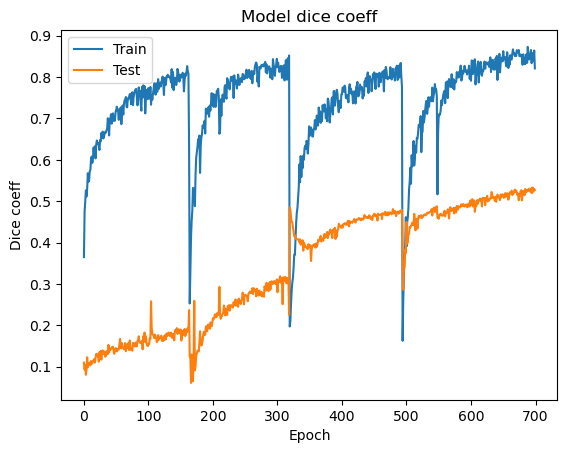

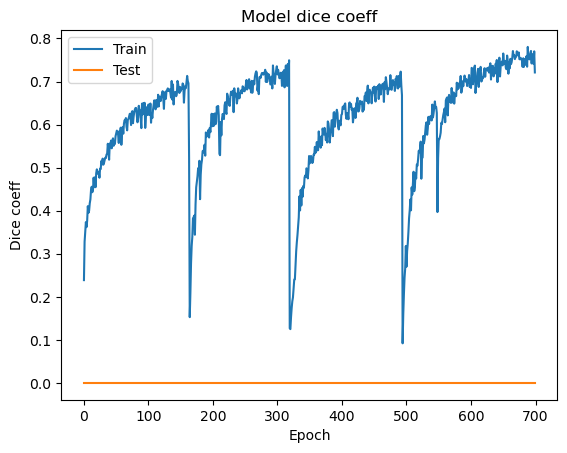

(array([[[-0.63130218, -0.63130218, -0.63130218, ..., -0.63130218,
          -0.63130218, -0.63130218],
         [-0.63130218, -0.63130218, -0.63130218, ..., -0.63130218,
          -0.63130218, -0.63130218],
         [-0.63130218, -0.63130218, -0.63130218, ..., -0.63130218,
          -0.63130218, -0.63130218],
         ...,
         [-0.63130218, -0.63130218, -0.63130218, ..., -0.63130218,
          -0.63130218, -0.63130218],
         [-0.63130218, -0.63130218, -0.63130218, ..., -0.63130218,
          -0.63130218, -0.63130218],
         [-0.63130218, -0.63130218, -0.63130218, ..., -0.63130218,
          -0.63130218, -0.63130218]],
 
        [[-0.63130218, -0.63130218, -0.63130218, ..., -0.63130218,
          -0.63130218, -0.63130218],
         [-0.63130218, -0.63130218, -0.63130218, ..., -0.63130218,
          -0.63130218, -0.63130218],
         [-0.63130218, -0.63130218, -0.63130218, ..., -0.63130218,
          -0.63130218, -0.63130218],
         ...,
         [-0.63130218, -0.6313021

In [35]:
train_and_predict_generator( continue_training=True, epochs=700)

------------------------------
Loading and preprocessing train data...
------------------------------
weights=[ 0.52056488 12.6566495 ]
------------------------------
Creating and compiling model...
[ 0.52056488 12.6566495 ]
------------------------------
model=<keras.engine.functional.Functional object at 0x79011cbaf550>
------------------------------
Fitting model...
------------------------------
[46]
1127
length random_numbers: 1
length processed_imgs_train: 882
length processed_imgs_mask_train: 882
Epoch 1/150
46/46 [==============================] - 44s 451ms/step - loss: 0.0916 - dice_coef: 0.2513 - accuracy: 0.9701 - IoU: 0.1505 - val_loss: 0.0882 - val_dice_coef: 0.0369 - val_accuracy: 0.9116 - val_IoU: 0.0000e+00
length random_numbers: 1
length processed_imgs_train: 1127
length processed_imgs_mask_train: 1127
Epoch 2/150
46/46 [==============================] - 17s 361ms/step - loss: 0.0314 - dice_coef: 0.3462 - accuracy: 0.9883 - IoU: 0.2234 - val_loss: 0.0067 - val_dice_coe

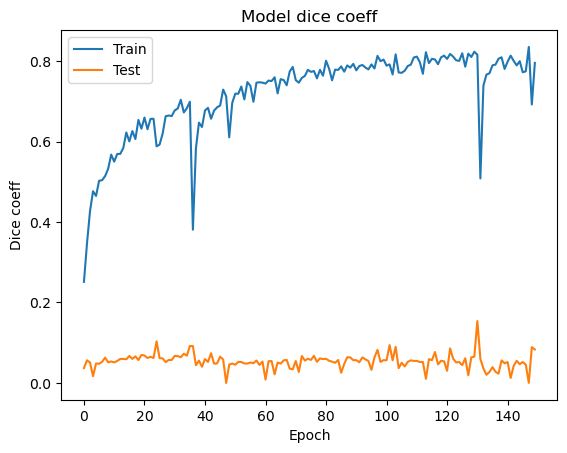

(array([[[-0.63130218, -0.63130218, -0.63130218, ..., -0.63130218,
          -0.63130218, -0.63130218],
         [-0.63130218, -0.63130218, -0.63130218, ..., -0.63130218,
          -0.63130218, -0.63130218],
         [-0.63130218, -0.63130218, -0.63130218, ..., -0.63130218,
          -0.63130218, -0.63130218],
         ...,
         [-0.63130218, -0.63130218, -0.63130218, ..., -0.63130218,
          -0.63130218, -0.63130218],
         [-0.63130218, -0.63130218, -0.63130218, ..., -0.63130218,
          -0.63130218, -0.63130218],
         [-0.63130218, -0.63130218, -0.63130218, ..., -0.63130218,
          -0.63130218, -0.63130218]],
 
        [[-0.63130218, -0.63130218, -0.63130218, ..., -0.63130218,
          -0.63130218, -0.63130218],
         [-0.63130218, -0.63130218, -0.63130218, ..., -0.63130218,
          -0.63130218, -0.63130218],
         [-0.63130218, -0.63130218, -0.63130218, ..., -0.63130218,
          -0.63130218, -0.63130218],
         ...,
         [-0.63130218, -0.6313021

In [38]:
train_and_predict_generator( continue_training=True , epochs=150)

In [31]:
test_h5_filename="/kaggle/input/patients/Test2Pacienty.h5"
imgs_test, imgs_maskt= read_h5_2(test_h5_filename)
imgs_test = resizes(imgs_test)
imgs_maskt = preprocess(imgs_maskt, is_mask=True)
#imgs_train = imgs_test.astype('float32')
mean = np.mean(imgs_test)  # mean for data centering
std = np.std(imgs_test)  # std for data normalization

imgs_test -= mean
imgs_test /= std
#Normalization of the train set

#imgs_mask_test = imgs_mask_test.astype('float32')

print(f"Number of frames={imgs_test.shape[0]}")

Number of frames=724


In [38]:
model = get_unet2()

# model.load_weights('weights_liver_slides.h5')
model.load_weights('/kaggle/input/weights/weights.h5')

print('-'*30)
print('Predicting masks on test data...')
print('-'*30)

imgs_mask_test_pred = model.predict(imgs_test, verbose=1)

------------------------------
Predicting masks on test data...
------------------------------
23/23 [==============================] - 205s 9s/step


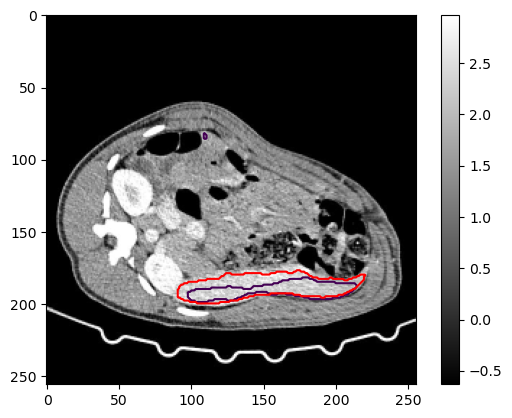

In [39]:
i =200

plt.imshow(imgs_test[i,:,:,0], cmap='gray')
plt.colorbar()
plt.contour(imgs_mask_test_pred[i,:,:,0]>0.5)
plt.contour(imgs_maskt[i,:,:,0]>0.5, colors="red")

In [40]:
IoU(imgs_maskt,imgs_mask_test_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.6412921>

In [34]:
#NameError: name 'mark_boundaries' is not defined
from skimage.segmentation import mark_boundaries

ImportError: cannot import name 'QhullError' from 'scipy.spatial' (/opt/conda/lib/python3.10/site-packages/scipy/spatial/__init__.py)